# Getting started

To demonstrate how BayKer can be used to model kernel phases, we will use the PHARO data from the [Xara tutorial](https://frantzmartinache.eu/xara_doc/04_pharo_data_analysis_example.html).

## Data Download

We will first download the data from Xara's GitHub if it is not already available locally.

In [1]:
import urllib.request
from pathlib import Path

tgt_filename = "tgt_cube.fits"
cal_filename = "ca2_cube.fits"
pupil_filename = "p3k_med_grey_model.fits"
dir_url = "https://github.com/fmartinache/xara/raw/master/tests/data/PHARO/"
data_dir = Path("./data")
data_dir.mkdir(exist_ok=True)

for filename in [tgt_filename, cal_filename, pupil_filename]:
    download_path = data_dir /filename
    url = dir_url + filename
    if not download_path.exists():
        urllib.request.urlretrieve(url, download_path)
        print(f"Downloaded {download_path}")
    else:
        print(f"{download_path} already exists")

data/tgt_cube.fits already exists
data/ca2_cube.fits already exists
data/p3k_med_grey_model.fits already exists


## Kernel Phase Extraction

BayKer works with _extracted_ kernel phase data. This means we need to process the image cubes with Xara before doing our analysis.
We will not cover this step in detail as it is already explained in the [Xara documentation](https://frantzmartinache.eu/xara_doc/04_pharo_data_analysis_example.html).

In [2]:
from xara.kpo import KPO
from astropy.io import fits

model_path = data_dir / pupil_filename
kpo_tgt = KPO(fname=model_path)
kpo_cal = kpo_tgt.copy()

pscale = 25.0  # plate scale of the image in mas/pixels
wl = 2.145e-6  # central wavelength in meters (Hayward paper)

tgt_path = data_dir / tgt_filename
with fits.open(tgt_path) as hdul:
    tgt_cube = hdul[0].data
cal_path = data_dir / cal_filename
with fits.open(cal_path) as hdul:
    cal_cube = hdul[0].data

kpo_tgt.extract_KPD_single_cube(tgt_cube, pscale, wl,target="alpha Ophiuchi", recenter=True)
kpo_cal.extract_KPD_single_cube(cal_cube, pscale, wl, target="epsilon Herculis", recenter=True)

Attempting to load file data/p3k_med_grey_model.fits
KPI data successfully loaded
The file contains 0 data-sets
CWAVEL was not set
No covariance data available
Cube slice   1 / 100
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...
Done!
Cube slice 100 / 100

Cube slice   1 / 100
First time for m2pix = 3.62: 
LDFT1: Computing new Fourier matrix...
Done!
Cube slice 100 / 100



We now have raw kernel phases for our science target and our reference star.
Kernel phase data is stored as `KPO` objects (KPO stands for Kernel Phase Observation).
Their most important attributes are:

- `KPDT`: A list of extracted kernel phase datasets each with shape `(nint, nkp)`.
- `KPSIG`: A list of associated errors with the same shape as `KPDT`, if the errors were calculated
- `CWAVEL`: The central wavelength of the data
- `kpi`: The `KPI` object associated with the dataset. KPI stands for Kernel Phase Information and stores information about the pupil model used to convert the images to kernel phases. Its important attributes are:
  - `VAC`: The pupil-plane coordinate of the pupil models
  - `UVC`: The UV-plane coordinate of the baselines in the pupil model
  - `KPM`: The kernel phase matrix used to convert Fourier phases to kernel phases, with shape `(nkp, nph)`

In our case, `KPSIG` was not estimated, and `KPDT` has one element with shape `(100, 1048)`.

## Kernel Phase Calibration

Before taking our analysis further, we will estimate the kernel phase variance across the 100 frames and use the median as our best estimate. Since the KPO data format is a bit convoluted (with lists of arrays), we have helper function to do this.

We can then calibrate the kernel phases by subtracting the reference from the science target.

In [3]:
import bayker.utils as ut
kpo_tgt = ut.average_kpo(kpo_tgt)
kpo_cal = ut.average_kpo(kpo_cal)
kpo = ut.calibrate_kpo(kpo_tgt, kpo_cal)

<xara.kpo.KPO object at 0x7f5f97a94830> deleted
<xara.kpi.KPI object at 0x7f5f97a94980> deleted 
<xara.kpo.KPO object at 0x7f5f972fcb90> deleted
<xara.kpi.KPI object at 0x7f5f972fd590> deleted 


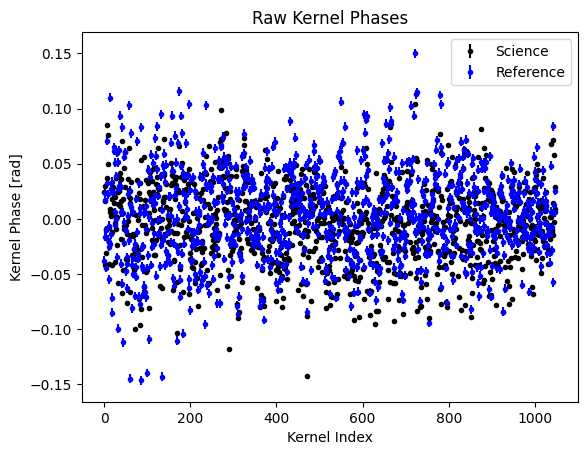

In [4]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(kpo.KPDT[0].shape[-1])

plt.errorbar(x, kpo_tgt.KPDT[0][0], kpo_tgt.KPSIG[0][0], fmt="k.", label="Science")
plt.errorbar(x, kpo_cal.KPDT[0][0], kpo_cal.KPSIG[0][0], fmt="b.", label="Reference")
plt.xlabel("Kernel Index")
plt.ylabel("Kernel Phase [rad]")
plt.title("Raw Kernel Phases")
plt.legend()
plt.show()

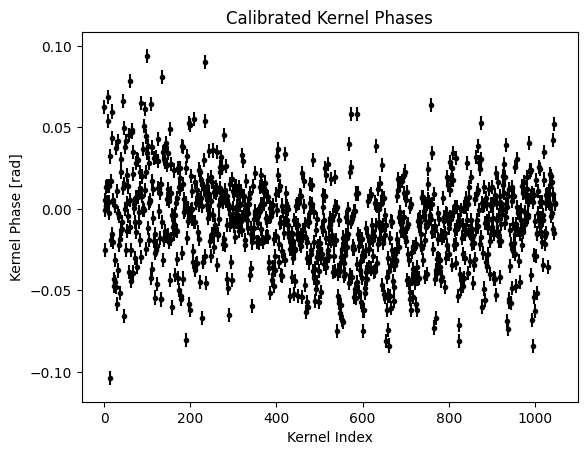

In [5]:
plt.errorbar(x, kpo.KPDT[0][0], kpo.KPSIG[0][0], fmt="k.")
plt.xlabel("Kernel Index")
plt.ylabel("Kernel Phase [rad]")
plt.title("Calibrated Kernel Phases")
plt.show()

## Colinearity Map

As you might have noticed above, kernel phase data is not exactly intuitive to look at...
Before diving into the Bayesian analysis, we can get a quick sense of whether there is some signal in the data by doing a _colinearity map_ (also called _cross-correlation_ map).
Basically, this map shows a dot product of the data and a binary signal for all positions on a grid.
The contrast remains fixed but would only scale the entire map by a constant factor anyways.

In [6]:
from bayker.search import get_colinearity_map
cmap, pos_grid = get_colinearity_map(kpo, 100, (-400, 400), return_pos=True)

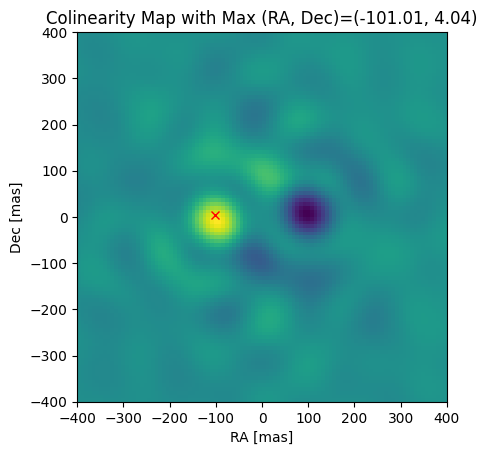

In [7]:
dec_idx, ra_idx = np.unravel_index(np.argmax(cmap), (100, 100))
max_ra = pos_grid["ra"][ra_idx]
max_dec = pos_grid["dec"][dec_idx]
plt.imshow(cmap, extent=(-400, 400, -400, 400))
plt.plot(max_ra, max_dec, "rx")
plt.xlabel("RA [mas]")
plt.ylabel("Dec [mas]")
plt.title(f"Colinearity Map with Max (RA, Dec)=({max_ra:.2f}, {max_dec:.2f})")
plt.show()

## Bayesian Model

We are now ready to build our Bayesian kernel phase model.
BayKer provides `KernelModel` class.
We need to give it a parameter dictionary with the priors and a `KPO` object with the data and pupil model information.
We can also optionally specify the binary model parametrization with the `pos_param` argument.
Here we stick to the default `seppa`. The alternative would be `radec`.

`KernelModel` is built with `simpple` so it has all the usual attributes and methods (`parameters`, `forward`, `log_likelihood`, etc.).
The forward model in `KernelModel` takes parameter values as input and returns the associated kernel phases.
There is also an optional `sigma` parameter that will be added in quadrature to the kernel phase errors in the likelihood.

In [8]:
import simpple.distributions as sdist
from bayker.model import KernelModel

parameters = {
    "sep": sdist.LogUniform(1e-5, 600.0),
    "pa": sdist.Uniform(0, 360.0),
    "cr": sdist.LogUniform(1e-5, 1.0),
    "sigma": sdist.LogUniform(1e-5, 10.0),
}
model = KernelModel(parameters, kpo)

### Prior samples

First, let us look at prior samples in a corner plot to make sure the model specification is what we expect.

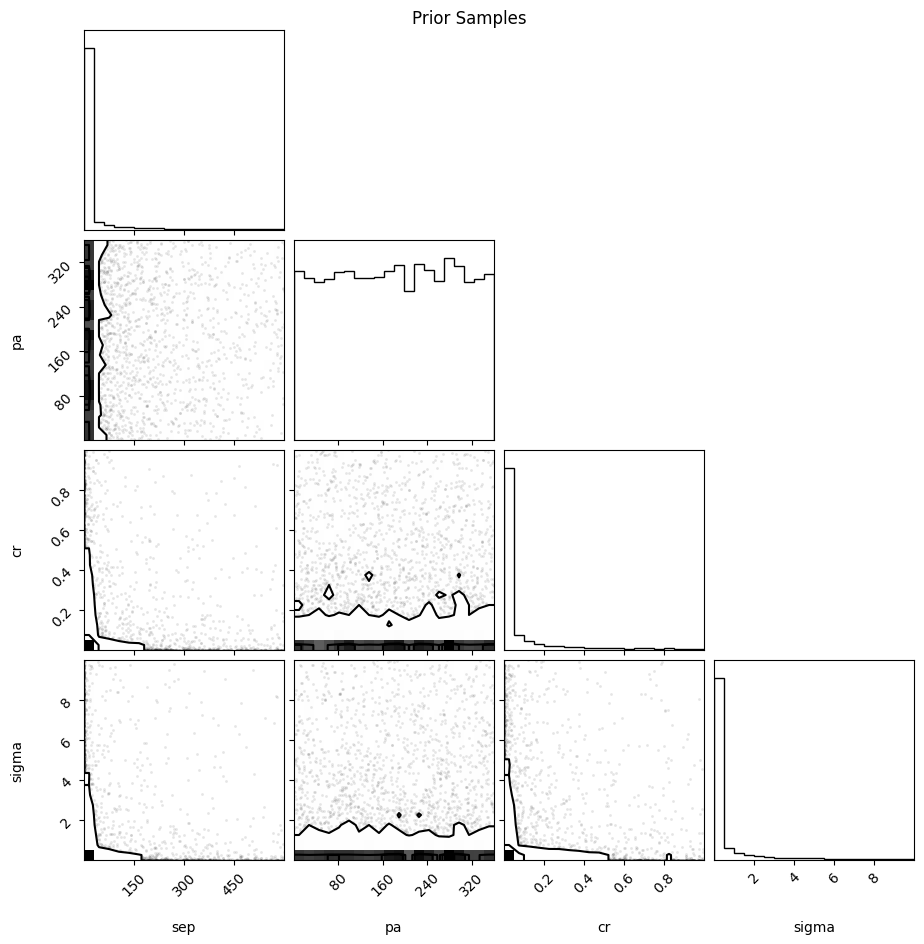

In [9]:
import corner
prior_samples = model.get_prior_samples(10000)
fig = corner.corner(prior_samples)
fig.suptitle("Prior Samples")
plt.show()

And let us also look at prior predictive samples to make sure forward models drawn from the prior cover the data and look reasonable.
To plot the data, we will use the helper function `plot_kernel` from `bayker.plot`.

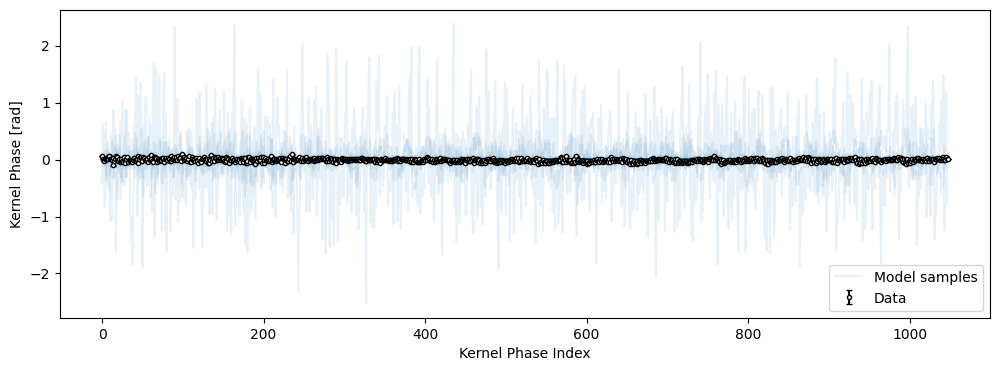

In [10]:
from bayker.plot import plot_kernel

plot_kernel(model, parameters=prior_samples, residuals=False)
plt.show()

### Sampling the Posterior

Now we can sample the posterior. We will use [UltraNest](https://johannesbuchner.github.io/UltraNest/index.html) for this example.
Ultranest shows a lot of debug information so we wrap it in a function that turns off logging.

In [11]:
import logging
from ultranest import ReactiveNestedSampler
from ultranest.stepsampler import SliceSampler, generate_mixture_random_direction
def run_ultranest(model: KernelModel) -> ReactiveNestedSampler:
    wrapped = [k.startswith("pa") for k in model.keys()]
    nested_sampler = ReactiveNestedSampler(
        model.keys(),
        model.log_likelihood,
        model.prior_transform,
        wrapped_params=wrapped,
    )
    if len(model.keys()) > 4:
        nsteps = len(model.keys()) * 2
        nested_sampler.stepsampler = SliceSampler(
            nsteps=nsteps,
            generate_direction=generate_mixture_random_direction,
        )
    # HACK: Force all existing loggers to WARNING
    # Ultranest has DEBUG when running after corner for some reason
    logging.getLogger().setLevel(logging.WARNING)
    for logger_name in logging.root.manager.loggerDict:
        logging.getLogger(logger_name).setLevel(logging.WARNING)

    nested_sampler.run(show_status=False);
    return nested_sampler

In [12]:
nested_sampler = run_ultranest(model)

DEBUG:ultranest:ReactiveNestedSampler: dims=4+0, resume=False, log_dir=None, backend=hdf5, vectorized=False, nbootstraps=30, ndraw=128..65536


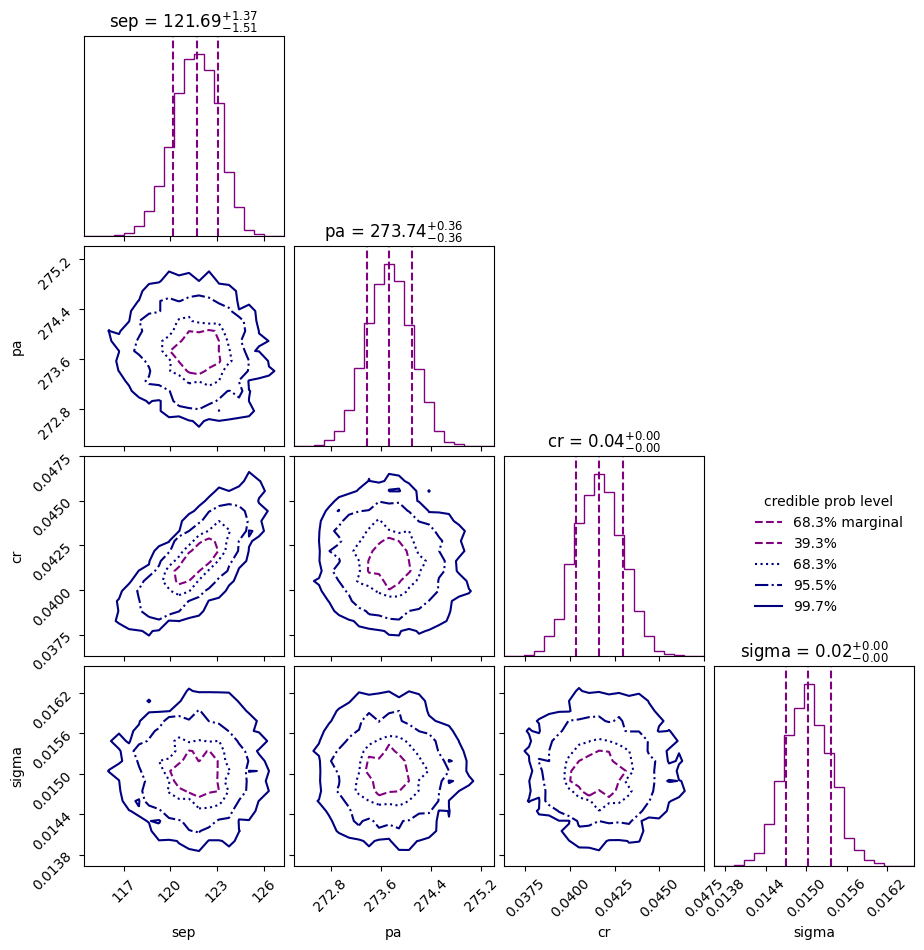

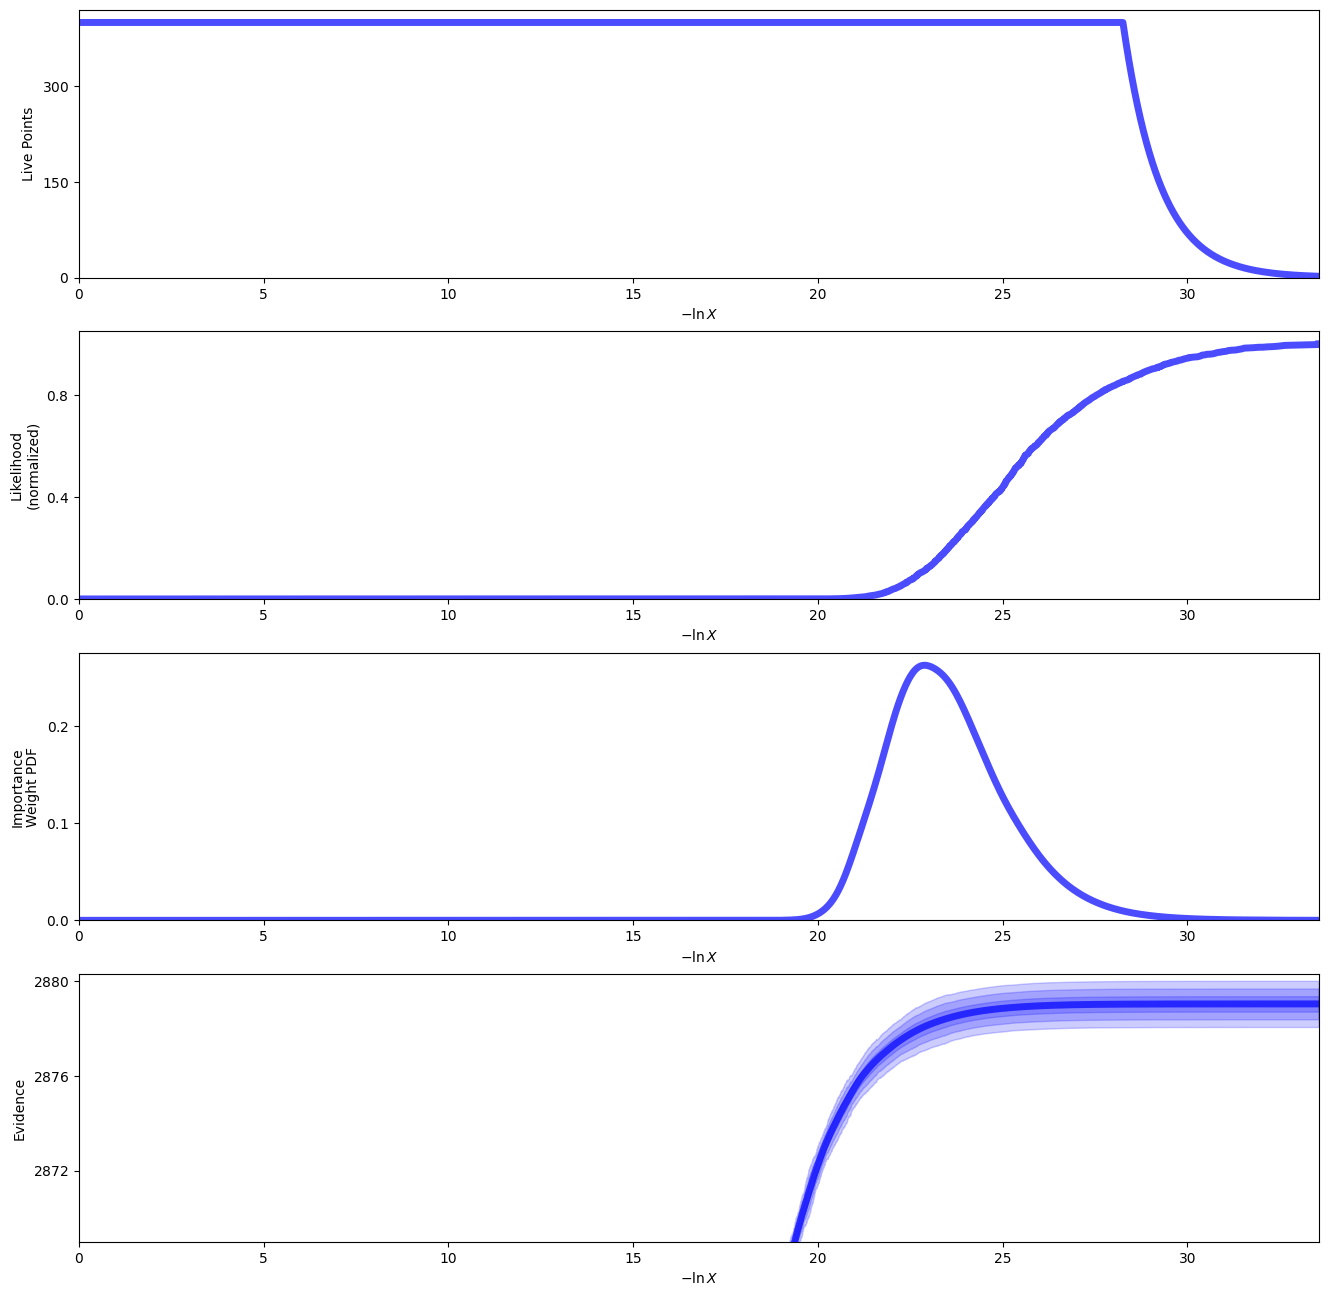

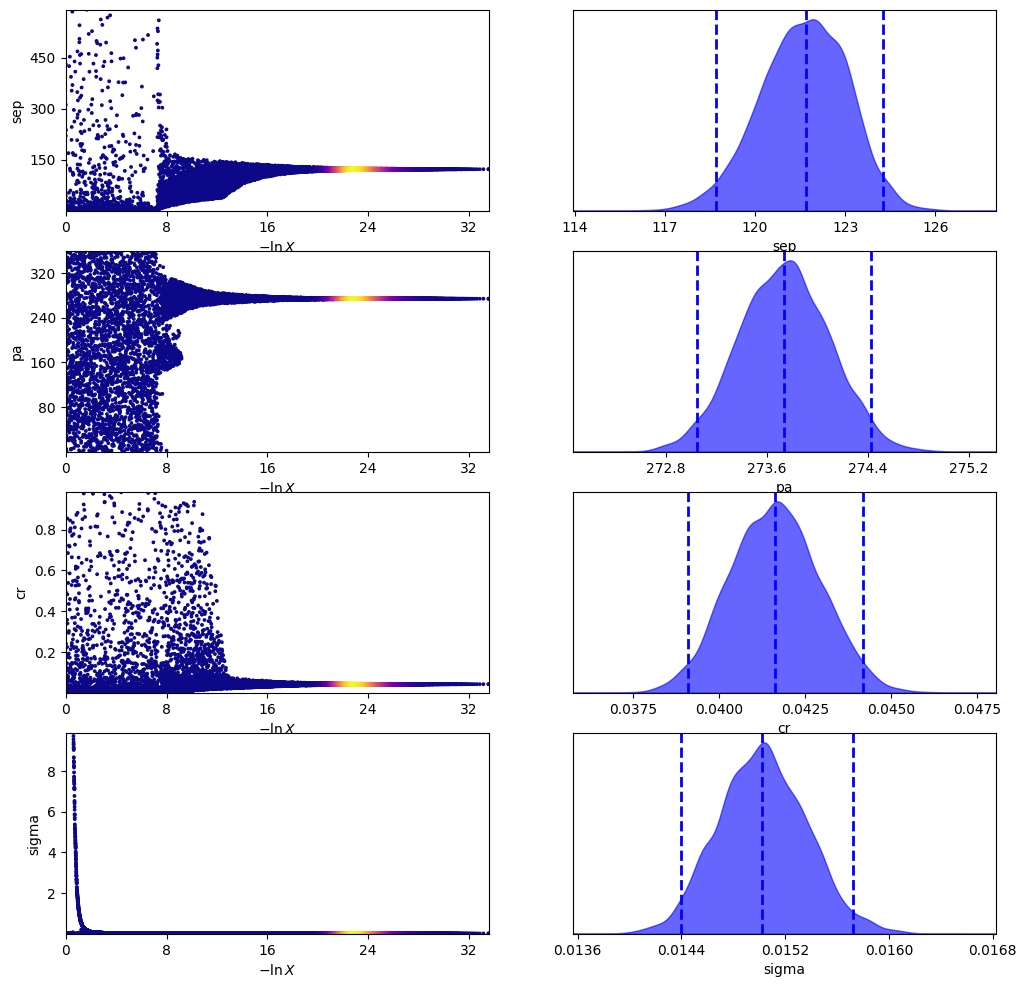

In [13]:
nested_sampler.plot()
plt.show()

This looks good! Let's see graphically how the model matches the data.

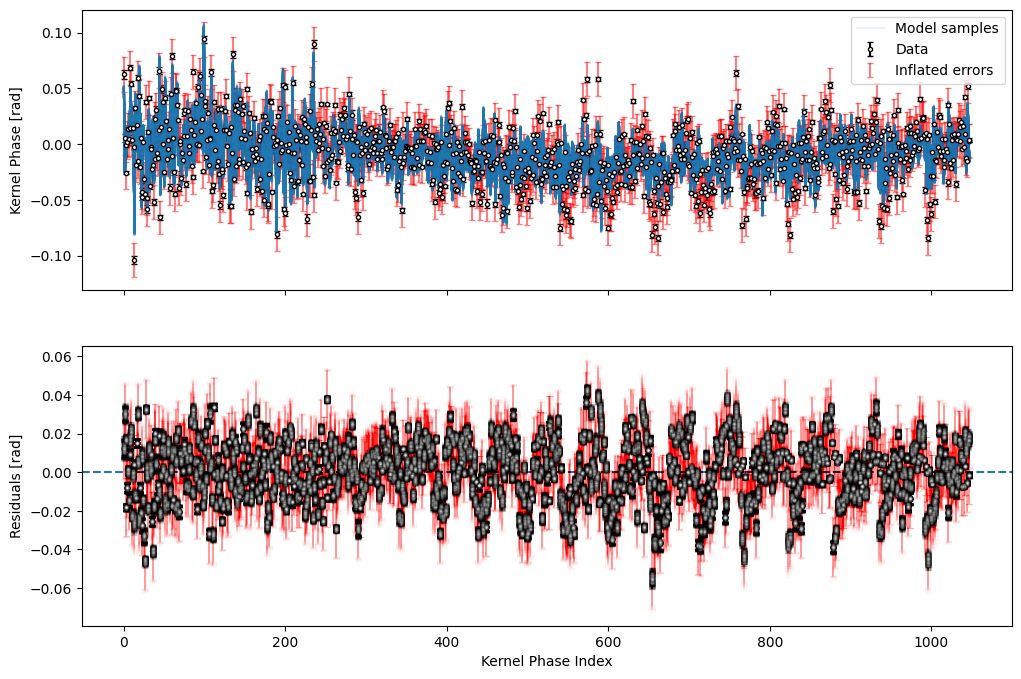

In [14]:
plot_kernel(model, parameters=nested_sampler.results["samples"].T, include_sigma=True)
plt.show()

Since the x-axis is just a numerical index, it is also quite common to just show the model vs the data.
We will use the median samples from the sampler for this.
We also show the effect of the `sigma` term in red.

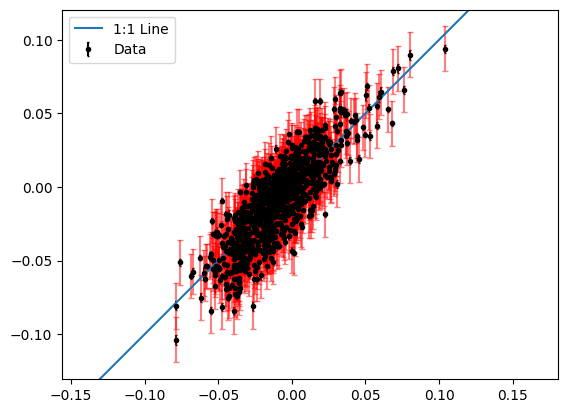

In [15]:
med_p = np.median(nested_sampler.results["samples"], axis=0)
med_pred = model.forward(med_p)
med_p_dict = dict(zip(model.keys(), med_p))
inflated_ekp = np.sqrt(model.kpo.ekp**2 + med_p_dict["sigma"]**2)
plt.errorbar(med_pred, model.kpo.kp, yerr=model.kpo.ekp, fmt="k.", label="Data", capsize=1)
plt.errorbar(med_pred, model.kpo.kp, yerr=inflated_ekp, ecolor="r", fmt="none", alpha=0.5, capsize=2)
plt.axline((0, 0), slope=1, label="1:1 Line")
plt.legend()
plt.axis("equal")
plt.show()

## Bayesian Model Comparison

The nested sampling run above gave us the Bayesian evidence for a binary model.
The null model corresponding to a centered point source for a kernel phase dataset is a straight line.
However, to provide a fair comparison to our binary model above, we must allow a "sigma" term to inflate the error bars around the straight line.

We can build such a model with BayKer using the `model_type` argument and sample it with UltraNest again.

In [16]:
parameters_single = {"sigma": sdist.LogUniform(1e-5, 10.0)}
model_single = KernelModel(parameters_single, kpo, model_type="single")

In [17]:
nested_sampler_single = run_ultranest(model_single)

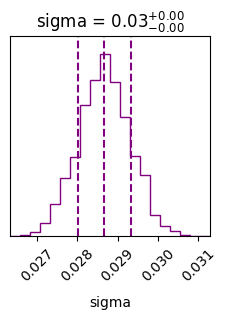

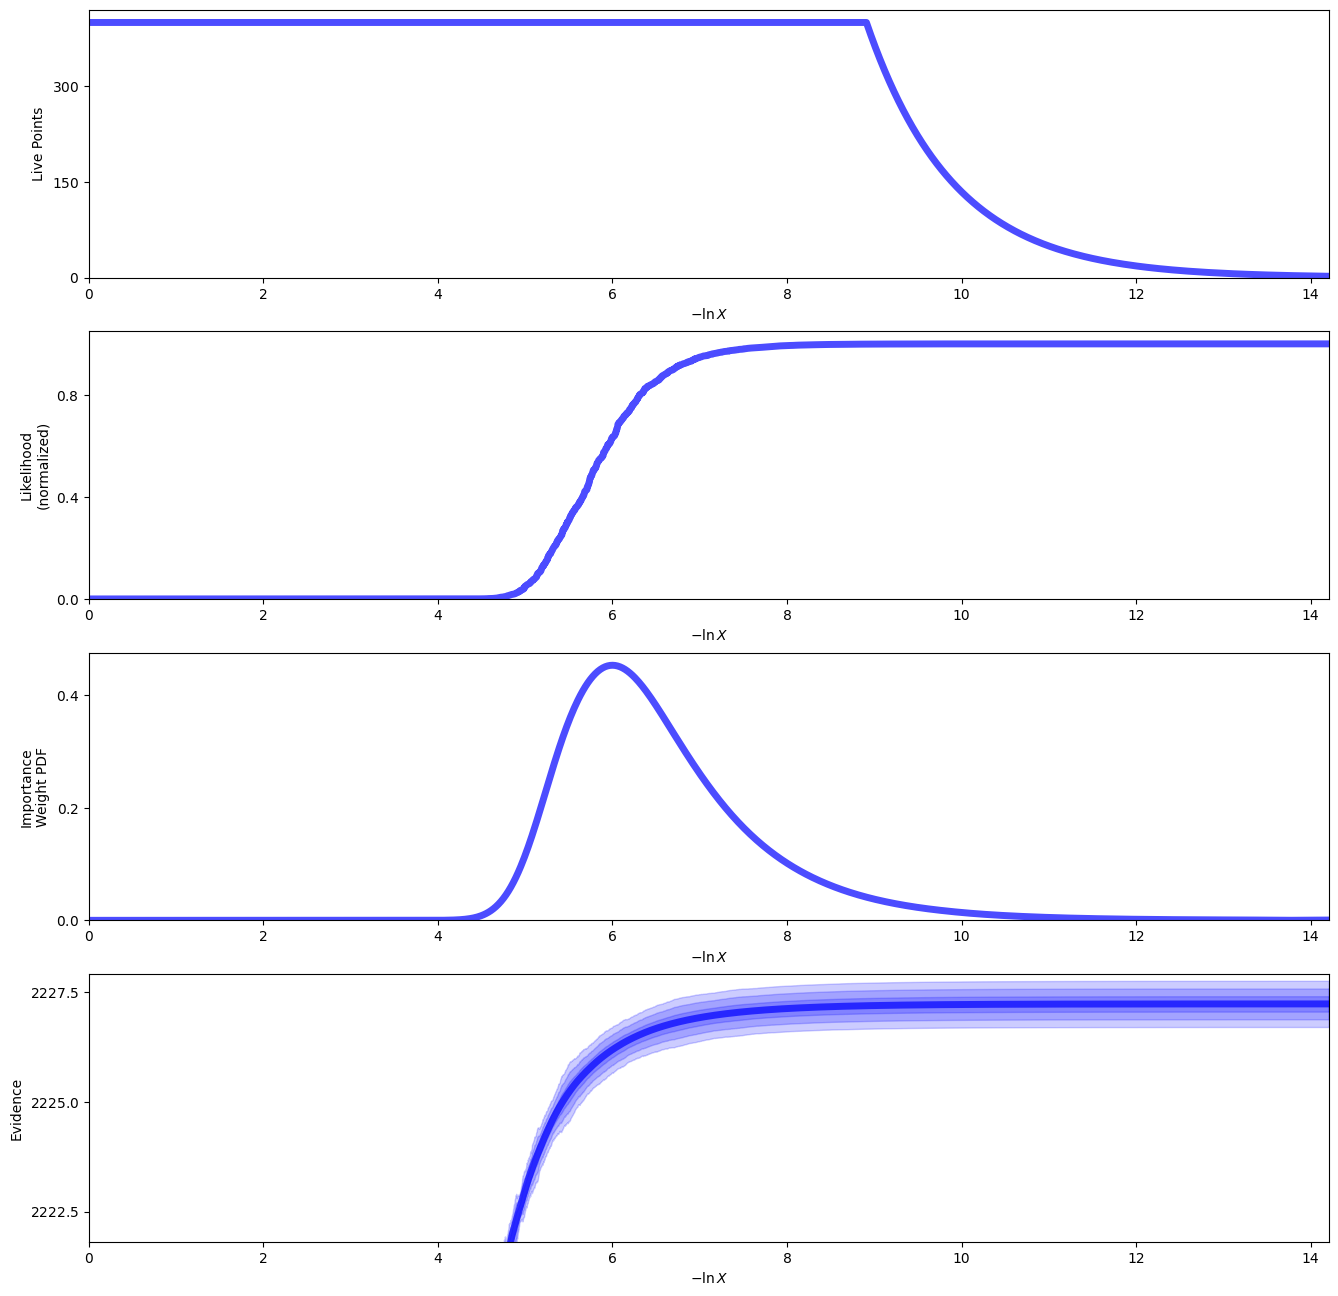

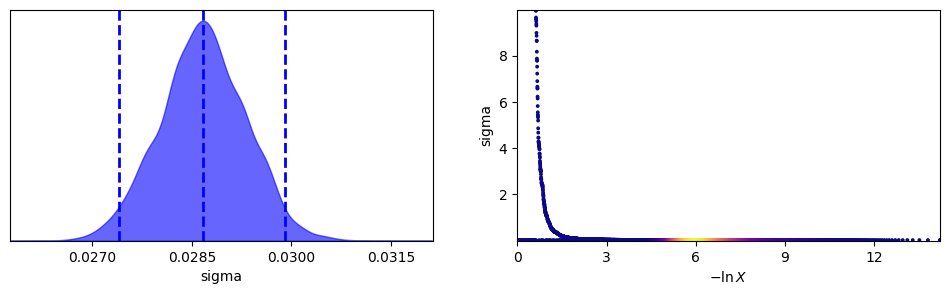

In [18]:
nested_sampler_single.plot()
plt.show()

That was much quicker than the binary model!
Let us now extract the evidence for both models and calculate the bayes factor

In [19]:
print(f"lnZ single: {nested_sampler_single.results['logz']:.2f} +/- {nested_sampler_single.results['logzerr']:.2f}")
print(
    f"lnZ binary: {nested_sampler.results['logz']:.2f} +/- {nested_sampler.results['logzerr']:.2f}"
)
lnK = nested_sampler.results["logz"] - nested_sampler_single.results["logz"]
lnK_err = np.sqrt(
    nested_sampler_single.results["logzerr"] ** 2 + nested_sampler.results["logzerr"] ** 2
)
print(f"lnK binary - single: {lnK:.2f} +/- {lnK_err:.2f}")

lnZ single: 2227.23 +/- 0.30
lnZ binary: 2879.05 +/- 0.35
lnK binary - single: 651.82 +/- 0.46


Without too much surprise, the Bayes factor very strongly favors the binary model compared to a straight line.